In [ ]:
# 1. Download dan Extract Dataset
import os

# Buat direktori dataset
if not os.path.exists('dataset'):
    os.makedirs('dataset')

# Download menggunakan curl sesuai request
print("Downloading dataset...")
!curl -L -o dataset/person-segmentation.zip "https://www.kaggle.com/api/v1/datasets/download/nikhilroxtomar/person-segmentation"

# Unzip
print("Extracting dataset...")
!unzip -q dataset/person-segmentation.zip -d dataset/
print("Done!")

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  461M  100  461M    0     0   168M      0  0:00:02  0:00:02 --:--:--  205M
Extracting dataset...
Done!



=== PENGECEKAN DATASET (DEBUG) ===
Image Shape Input: (4, 256, 256, 3) (Range: 0.0 - 255.0)
Mask Shape Input : (4, 256, 256, 1)
Nilai Unik Mask  : [0. 1.] (Harus [0. 1.] atau mendekati)
Gambar pengecekan disimpan ke 'debug_dataset_check.png'. SILAKAN CEK FILE INI!
Jika kotak kanan HITAM SEMUA, berarti mask Anda masih salah format.



/usr/local/lib/python3.12/dist-packages/keras/src/applications/mobilenet_v3.py:517: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Mulai Training...
Epoch 1/46


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


638/638 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - binary_accuracy: 0.8170 - dice_coef: 0.6210 - loss: 0.7985
Epoch 1: val_dice_coef improved from -inf to 0.84334, saving model to best_model_fixed.keras
638/638 ━━━━━━━━━━━━━━━━━━━━ 134s 101ms/step - binary_accuracy: 0.8171 - dice_coef: 0.6212 - loss: 0.7981 - val_binary_accuracy: 0.9480 - val_dice_coef: 0.8433 - val_loss: 0.3072 - learning_rate: 1.0000e-04
Epoch 2/46
638/638 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - binary_accuracy: 0.9354 - dice_coef: 0.8280 - loss: 0.3507
Epoch 2: val_dice_coef improved from 0.84334 to 0.86847, saving model to best_model_fixed.keras
638/638 ━━━━━━━━━━━━━━━━━━━━ 56s 88ms/step - binary_accuracy: 0.9354 - dice_coef: 0.8280 - loss: 0.3507 - val_binary_accuracy: 0.9515 - val_dice_coef: 0.8685 - val_loss: 0.2711 - learning_rate: 1.0000e-04
Epoch 3/46
638/638 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - binary_accuracy: 0.9438 - dice_coef: 0.8522 - loss: 0.3014
Epoch 3: val_dice_coef improved from 0.86847 to 0.89036, saving mode

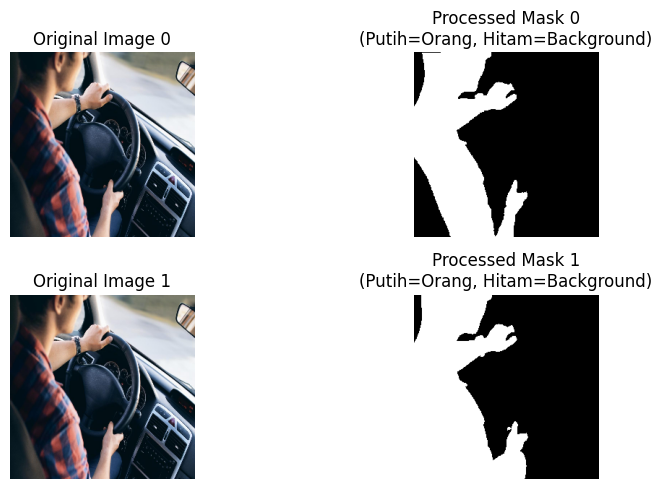

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, Input, callbacks
from tensorflow.keras.applications import MobileNetV3Large
from sklearn.model_selection import train_test_split
import albumentations as A

# ==========================================
# 1. KONFIGURASI & HYPERPARAMETERS
# ==========================================
IMG_SIZE = 256
BATCH_SIZE = 8
EPOCHS = 46
LR = 1e-4
DATA_DIR = "dataset/people_segmentation"

# ==========================================
# 2. AUGMENTASI (Safe Version)
# ==========================================
try:
    # Albumentations versi baru
    coarse_dropout = A.CoarseDropout(
        num_holes_range=(1, 8), hole_height_range=(1, 32), hole_width_range=(1, 32), p=0.2
    )
except (TypeError, AttributeError):
    # Albumentations versi lama
    coarse_dropout = A.CoarseDropout(
        max_holes=8, max_height=32, max_width=32, p=0.2
    )

train_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=45, p=0.5),
    A.ChannelShuffle(p=0.2),
    A.ToGray(p=0.1),
    coarse_dropout,
])

val_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
])

# ==========================================
# 3. DATA GENERATOR (DENGAN PERBAIKAN MASK)
# ==========================================
class RobustDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_paths, mask_paths, batch_size, augment=False):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.batch_size = batch_size
        self.augment = augment
        self.transforms = train_transform if augment else val_transform

    def __len__(self):
        return len(self.image_paths) // self.batch_size

    def __getitem__(self, index):
        batch_img_paths = self.image_paths[index*self.batch_size : (index+1)*self.batch_size]
        batch_mask_paths = self.mask_paths[index*self.batch_size : (index+1)*self.batch_size]

        images = []
        masks = []

        for i, img_path in enumerate(batch_img_paths):
            # --- 1. Baca Image ---
            img = cv2.imread(img_path)
            if img is None: continue
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # --- 2. Baca Mask ---
            mask = cv2.imread(batch_mask_paths[i], cv2.IMREAD_GRAYSCALE)
            if mask is None: continue

            # --- 3. Augmentasi ---
            if self.augment:
                transformed = self.transforms(image=img, mask=mask)
                img = transformed['image']
                mask = transformed['mask']
            else:
                img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE))

            # --- 4. Preprocessing Image ---
            # MobileNetV3 expect [0-255] float
            images.append(img.astype(np.float32))

            # --- 5. Preprocessing Mask ---
            # Deteksi otomatis range nilai pixel
            max_val = np.max(mask)

            if max_val > 1:
                # Jika format 0-255, bagi 255 lalu threshold tengah
                mask = mask.astype(np.float32) / 255.0
                mask = (mask > 0.5).astype(np.float32)
            else:
                # Jika format sudah 0-1, pastikan float
                mask = mask.astype(np.float32)
                # Opsional: cleaning noise
                mask = (mask > 0.5).astype(np.float32)

            mask = np.expand_dims(mask, axis=-1)
            masks.append(mask)

        return np.array(images), np.array(masks)

def get_dataset_paths(data_dir):
    img_dir = os.path.join(data_dir, "images")
    mask_dir = os.path.join(data_dir, "masks")

    if not os.path.exists(img_dir): return [], []

    # Sort penting agar urutan file image dan mask sinkron
    img_names = sorted([f for f in os.listdir(img_dir) if f.lower().endswith(('.jpg', '.png', '.jpeg'))])
    mask_names = sorted([f for f in os.listdir(mask_dir) if f.lower().endswith(('.png', '.jpg'))])

    # Pairing sederhana berdasarkan urutan sort
    img_paths = [os.path.join(img_dir, f) for f in img_names]
    mask_paths = [os.path.join(mask_dir, f) for f in mask_names]

    # Potong jika jumlah tidak sama
    min_len = min(len(img_paths), len(mask_paths))
    return img_paths[:min_len], mask_paths[:min_len]

# ==========================================
# 4. LOSS FUNCTION (Hybrid)
# ==========================================
def dice_coef(y_true, y_pred):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1e-5) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + 1e-5)

def bce_dice_loss(y_true, y_pred):
    # BCE untuk stabilitas awal, Dice untuk akurasi overlap
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    dice = 1.0 - dice_coef(y_true, y_pred)
    return bce + dice

# ==========================================
# 5. ARSITEKTUR MODEL (Keras 3 Compatible)
# ==========================================
def residual_decoder_block(input_tensor, skip_tensor, filters):
    x = layers.UpSampling2D((2, 2), interpolation='bilinear')(input_tensor)
    x = layers.Conv2D(filters, (1, 1), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)

    if skip_tensor is not None:
        # Resize skip tensor jika dimensi spasial beda (misal 16x16 vs 15x15)
        if x.shape[1] != skip_tensor.shape[1]:
            skip_tensor = layers.Resizing(x.shape[1], x.shape[2])(skip_tensor)

        skip = layers.Conv2D(filters, (1, 1), padding='same', use_bias=False)(skip_tensor)
        skip = layers.BatchNormalization()(skip)
        x = layers.Add()([x, skip]) # Paper Feature: ADDITION

    x = layers.ReLU()(x)

    # Residual Block
    residual = x
    x = layers.DepthwiseConv2D((3, 3), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters, (1, 1), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Add()([x, residual])
    x = layers.ReLU()(x)
    return x

def build_model():
    inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    base_model = MobileNetV3Large(input_tensor=inputs, include_top=False, weights='imagenet')

    # Logic pencarian layer dinamis
    layers_by_res = {}
    for layer in base_model.layers:
        try:
            output = layer.output
            if len(output.shape) == 4:
                h = output.shape[1]
                layers_by_res[h] = output
        except: continue

    s1 = layers_by_res.get(128) # 1/2
    s2 = layers_by_res.get(64)  # 1/4
    s3 = layers_by_res.get(32)  # 1/8
    bn = layers_by_res.get(16)  # 1/16 (Bottleneck)
    if bn is None: bn = base_model.output

    # Decoder
    x = bn
    x = residual_decoder_block(x, s3, 64)
    x = residual_decoder_block(x, s2, 64)
    x = residual_decoder_block(x, s1, 32)

    x = layers.UpSampling2D((2, 2), interpolation='bilinear')(x)
    x = layers.Resizing(IMG_SIZE, IMG_SIZE)(x)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid', padding='same')(x)

    return models.Model(inputs=inputs, outputs=outputs, name="Fixed_UNet_MobileNet")

# ==========================================
# 6. FUNGSI DEBUG & VISUALISASI
# ==========================================
def check_data_integrity(img_paths, mask_paths):
    """
    Fungsi ini SANGAT PENTING untuk memastikan mask terbaca dengan benar
    sebelum training dimulai.
    """
    print("\n=== PENGECEKAN DATASET (DEBUG) ===")
    temp_gen = RobustDataGenerator(img_paths[:4], mask_paths[:4], batch_size=4, augment=False)
    images, masks = temp_gen.__getitem__(0)

    print(f"Image Shape Input: {images.shape} (Range: {np.min(images)} - {np.max(images)})")
    print(f"Mask Shape Input : {masks.shape}")
    print(f"Nilai Unik Mask  : {np.unique(masks)} (Harus [0. 1.] atau mendekati)")

    # Plotting
    plt.figure(figsize=(10, 5))
    for i in range(min(2, len(images))):
        plt.subplot(2, 2, i*2 + 1)
        plt.imshow(images[i].astype('uint8'))
        plt.title(f"Original Image {i}")
        plt.axis('off')

        plt.subplot(2, 2, i*2 + 2)
        plt.imshow(masks[i].squeeze(), cmap='gray')
        plt.title(f"Processed Mask {i}\n(Putih=Orang, Hitam=Background)")
        plt.axis('off')

    plt.tight_layout()
    plt.savefig('debug_dataset_check.png')
    print("Gambar pengecekan disimpan ke 'debug_dataset_check.png'. SILAKAN CEK FILE INI!")
    print("Jika kotak kanan HITAM SEMUA, berarti mask Anda masih salah format.")
    print("==================================\n")

# ==========================================
# 7. MAIN EXECUTION
# ==========================================
# 1. Load Data
img_paths, mask_paths = get_dataset_paths(DATA_DIR)

# 2. Cek Visualisasi SEBELUM Training
check_data_integrity(img_paths, mask_paths)

# 3. Split & Generators
x_train, x_val, y_train, y_val = train_test_split(img_paths, mask_paths, test_size=0.1, random_state=42)
train_gen = RobustDataGenerator(x_train, y_train, BATCH_SIZE, augment=True)
val_gen = RobustDataGenerator(x_val, y_val, BATCH_SIZE, augment=False)

# 4. Build & Compile
tf.keras.backend.clear_session()
model = build_model()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
    loss=bce_dice_loss,
    metrics=[dice_coef, 'binary_accuracy']
)

# 5. Training
cbs = [
    callbacks.ModelCheckpoint('best_model_fixed.keras', save_best_only=True, monitor='val_dice_coef', mode='max', verbose=1),
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
    callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
]

print("Mulai Training...")
history = model.fit(train_gen, epochs=EPOCHS, validation_data=val_gen, callbacks=cbs)

In [ ]:
model.summary()

# Compress Model KE TFLite

In [ ]:
import tensorflow as tf
import os

MODEL_PATH = 'best_model_fixed.keras'
TFLITE_PATH = 'model_quantized.tflite'

print("1. Loading Keras model...")
# compile=False adalah KUNCI untuk menghindari error 'NoneType pop'
model = tf.keras.models.load_model(MODEL_PATH, compile=False)

print("2. Converting to TFLite...")
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Optimasi: Quantization (membuat model 4x lebih kecil dan lebih cepat)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model = converter.convert()

print("3. Saving TFLite model...")
with open(TFLITE_PATH, 'wb') as f:
    f.write(tflite_model)

print(f"Sukses! Model tersimpan di: {TFLITE_PATH}")